<a href="https://colab.research.google.com/github/cristobalperezp/MDS7202-Laboratorio/blob/main/Lab_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Laboratorio 7: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla, Ignacio Meza
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias, Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Cristóbal Pérez
- Nombre de alumno 2: Patricio Pérez


### **Link de repositorio de GitHub:** `https://github.com/cristobalperezp/MDS7202-Laboratorio`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [13]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
#!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la fabricación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [14]:
df_retail = pd.read_pickle('https://raw.githubusercontent.com/patricperz/MDS7202-Laboratorio/main/online_retail/online_retail_II_cleaned.pickle')
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [15]:
df_retail.dtypes, df_retail.shape

(Invoice              category
 StockCode            category
 Description            object
 Quantity                int64
 InvoiceDate    datetime64[ns]
 Price                 float64
 Customer ID          category
 Country              category
 dtype: object,
 (400947, 8))

## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.

- **Recency (R)**: Indica hace cuanto tiempo el cliente realizo su ultima compra. Notar que para este caso, mientras mas grande es el valor, menos interes posee el usuario para repetir una compra en uno de los locales.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t_{i})$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [16]:
df_retail= df_retail.sort_values(['Customer ID', 'InvoiceDate'])

In [17]:
df_retail['PreviousInvoiceDate'] = df_retail.groupby(['Customer ID'])['InvoiceDate'].shift()
df_retail['DaysBetweenVisits'] = (df_retail['InvoiceDate'] - df_retail['PreviousInvoiceDate']).dt.days

In [18]:
ivt = df_retail.groupby(['Invoice']).agg({
    'Customer ID': 'last',
    'DaysBetweenVisits': 'max'
}).reset_index()

In [19]:
Periodicity = ivt.groupby('Customer ID').agg({
    'DaysBetweenVisits': 'std'
})

In [20]:
Periodicity['DaysBetweenVisits']

Customer ID
12346.0     36.659999
12347.0     26.162951
12348.0           NaN
12349.0     88.791892
12351.0           NaN
              ...    
18283.0     59.628014
18284.0           NaN
18285.0           NaN
18286.0    174.655375
18287.0     60.591529
Name: DaysBetweenVisits, Length: 4314, dtype: float64

In [21]:
from datetime import datetime
def custom_features(dataframe_in):
    dataframe_in= dataframe_in.sort_values(['Customer ID', 'InvoiceDate'])

    first_visit = dataframe_in.groupby(['Customer ID'])['InvoiceDate'].min()
    last_visit = dataframe_in.groupby(['Customer ID'])['InvoiceDate'].max()
    Length	 = (last_visit - first_visit).dt.days

    latest = dataframe_in['InvoiceDate'].max()
    Recency = (latest - last_visit).dt.days

    #Price es el valor unitario, Quantity es la cantidad comprada, debemos generar 
    #una nueva columna que sea la multiplicación, luego con ello sacar la media
    aux = dataframe_in.copy()
    aux['Monetary'] = aux.loc[:,'Quantity'] * aux.loc[:,'Price']
    
    Monetary = aux.groupby('Customer ID')['Monetary'].mean()
    #Monetary = dataframe_in.groupby('Customer ID')['Price'].mean()

    Frequency = dataframe_in.groupby(['Customer ID'])['Invoice'].count()
    
    #Necesitamos hacer un shift sobre el InvoiceDate para cada customer
    aux['PreviousInvoiceDate'] = aux.groupby(['Customer ID'])['InvoiceDate'].shift()
    #Luego calcular las diferencias entre visitas
    aux['DaysBetweenVisits'] = (aux['InvoiceDate'] - aux['PreviousInvoiceDate']).dt.days
    #se agrega por invoice y obtenemos los valores deseados
    ivt = aux.groupby(['Invoice']).agg({
        'Customer ID': 'last',
        'DaysBetweenVisits': 'max'
        })
    #agegamos y calculamos std, rellenamos nulos con 0
    Periodicity = ivt.groupby('Customer ID').agg({
        'DaysBetweenVisits': 'std'
        })['DaysBetweenVisits'].fillna(0)

    lrmfp = pd.DataFrame(
        {
        'Length': Length,
        'Recency': Recency,
        'Monetary': Monetary,
        'Frequency': Frequency,
        'Periodicity': Periodicity  # int???
    },index = Length.index
    )

    return lrmfp


In [22]:
custom_features(df_retail).head()

,Length,Recency,Monetary,Frequency,Periodicity
Customer ID,,,,,
12346.0,196,164,11.298788,33,36.659999
12347.0,37,2,18.638310,71,26.162951
12348.0,0,73,11.108000,20,0.000000
12349.0,181,42,26.187647,102,88.791892
12351.0,0,10,14.330000,21,0.000000


**Respuesta de Pauta:**

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [23]:
class MinMax(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range
        self.min_ = None
        self.max_ = None
        self.feature_names_ = None

    def fit(self, X, y=None):
        self.min_ = X.min(axis=0)
        self.max_ = X.max(axis=0)
        self.feature_names_ = X.columns if hasattr(X, 'columns') else None

    def transform(self, X):
        if self.min_ is None or self.max_ is None:
            raise ValueError("Scaler has not been fitted.")
        
        X_scaled = (X - self.min_) / (self.max_ - self.min_)
        # LLevar al rango deseado si es que se da otro
        X_scaled = X_scaled * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]
        return X_scaled.values

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)

### 1.3.2 `T-SNE` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo `T-SNE` de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [24]:
lrmfp_transformer = FunctionTransformer(
    custom_features
)

In [25]:
ct = ColumnTransformer(
    [
        (
            'Scaler',
            MinMax(),
            custom_features(df_retail).columns
        )
    ],
    remainder='passthrough'
)

In [26]:
projector_pipe = Pipeline([
    ('LRMFP', lrmfp_transformer),
    ('scaling', ct),
    ('tsne', TSNE(n_components=2))
])

In [27]:
projections = pd.DataFrame(
    projector_pipe.fit_transform(df_retail), columns=["x_tsne", "y_tsne"]
    )
projections

,x_tsne,y_tsne
0,-2.974164,8.815698
1,-15.937896,-28.112022
2,-62.384884,-22.921303
3,13.497694,18.621166
4,24.986034,-45.275806
...,...,...
4309,31.822889,2.361194
4310,-53.990494,-32.647797
4311,-10.715549,50.004032
4312,11.013755,35.870834


In [28]:
px.scatter(
    projections,
    x="x_tsne",
    y="y_tsne",
)

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero **permutando el algoritmo de reducción de dimensionalidad por k-means.**

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

lrmfp_transformer = FunctionTransformer(
    custom_features
)

ct = ColumnTransformer(
    [
        (
            'Scaler',
            MinMax(),
            custom_features(df_retail).columns
        )
    ],
    remainder='passthrough'
)

# Reemplaza 'tsne' en el pipeline con 'kmeans'
# Deja un marcador de posición para el número de clusters (n_clusters)
projector_pipe = Pipeline([
    ('LRMFP', lrmfp_transformer),
    ('scaling', ct),
    ('kmeans', 'passthrough')  # passthrough significa que 'kmeans' se establecerá más tarde
])

# Rango de valores de k
k_values = range(1, 21)

# Almacena los resultados
elbow_results = []

for k in k_values:
    # Configura 'kmeans' en el pipeline
    projector_pipe.set_params(kmeans=KMeans(n_clusters=k))
    
    # Ajusta los datos
    projector_pipe.fit(df_retail)
    
    # Obtiene el puntaje de la inercia del modelo
    elbow_results.append(projector_pipe.named_steps['kmeans'].inertia_)

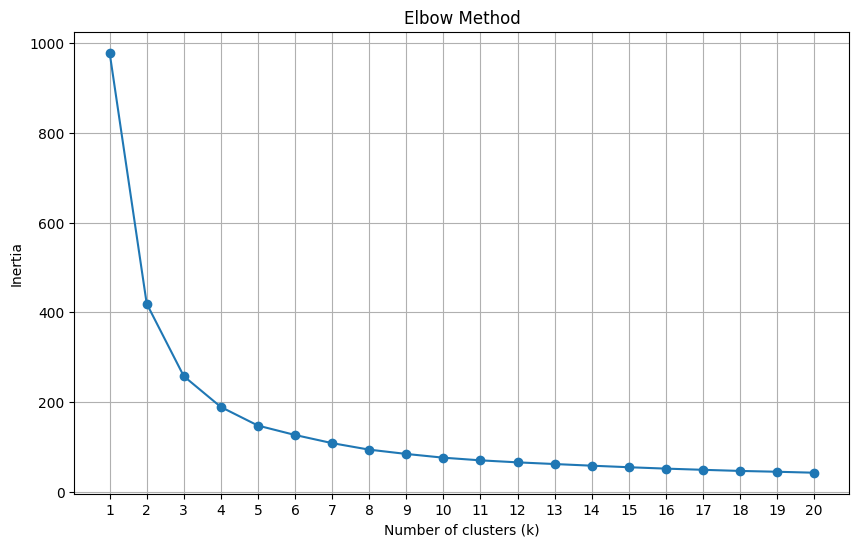

In [36]:
# Graficando los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, elbow_results, 'o-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
# Solo enteros en el eje x
plt.xticks(k_values)
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Inercia: Se refiere a la suma de las distancias cuadradas de cada muestra a su centroide más cercano. Un valor de inercia más bajo indica que los puntos de datos están más cerca de sus centroides, es decir, los clusters son más compactos. Sin embargo, la inercia tiende a disminuir naturalmente a medida que aumenta el número de clusters, lo que puede llevar a sobreajustes si se selecciona el número de clusters basándose únicamente en minimizar la inercia. Se utiliza comúnmente en el método del codo para seleccionar el número óptimo de clusters.

El valor "óptimo" de clusteres en el metodo del codo se elige cuando la inercia deja de disminuir significativamente con cada iteración. En este caso, se puede observar que la inercia deja de disminuir significativamente a partir de k=3, por lo que se escogería este valor para realizar el k-means.

Este método no es perfecto y no siempre es fácil de elegir el número óptimo de clusters. Por ejemplo, en este caso, se podría argumentar que k=4 es una mejor opción que k=3, ya que la inercia disminuye significativamente entre k=3 y k=4. Sin embargo, en este caso, se escogería k=3 ya que es el valor que presenta la mayor disminución en la inercia.

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

In [40]:
# k optimo del metodo del codo
k_optimo = 3 

# Ajusta el pipeline con el número óptimo de clusters
projector_pipe.set_params(kmeans=KMeans(n_clusters=k_optimo))
projector_pipe.fit(df_retail)

# Obtiene las etiquetas de los clusters
cluster_labels = projector_pipe.named_steps['kmeans'].labels_

# Crea una copia del DataFrame original y agrega las etiquetas de los clusters
df_clustered = custom_features(df_retail).copy()
df_clustered['Cluster'] = cluster_labels

# Calcula las medias (o medianas) de cada atributo para cada cluster
cluster_summary = df_clustered.groupby('Cluster').mean()  # o .median() para medianas

# Calcula el conteo por cada cluster y añade este conteo al DataFrame de resumen
cluster_counts = df_clustered['Cluster'].value_counts()
cluster_summary['Count'] = cluster_counts

# Muestra el resultado
cluster_summary.head()


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,Length,Recency,Monetary,Frequency,Periodicity,Count
Cluster,,,,,,
0,271.401288,38.502146,31.540454,162.040236,66.125035,1864
1,33.723816,52.563042,33.227255,47.985991,14.077431,1499
2,22.458465,251.168244,53.588443,28.362776,10.445682,951


**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

Para recordar:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.

- **Recency (R)**: Indica hace cuanto tiempo el cliente realizo su ultima compra. Notar que para este caso, mientras mas grande es el valor, menos interes posee el usuario para repetir una compra en uno de los locales.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

Si hay agrupaciones coherentes, se puede ver como por ejemplo el cluster 2 tiene un valor de periodicity muy bajo, lo que indica que los clientes de este cluster no visitan las tiendas con regularidad. Por otro lado, el cluster 0 tiene un valor de periodicity muy alto, lo que indica que los clientes de este cluster visitan las tiendas con regularidad. 

Este mismo fenómeno podemos verlo para length, donde el cluster 2 tiene un valor muy bajo, lo que indica que los clientes de este cluster no son muy fieles, mientras que el cluster 0 tiene un valor muy alto, lo que indica que los clientes de este cluster son muy fieles.

Para la variable recency podemos ver que el cluster 2 tiene un valor muy alto, lo que indica que los clientes de este cluster no han realizado compras recientemente, mientras que el cluster 0 tiene un valor muy bajo, lo que indica que los clientes de este cluster han realizado compras recientemente.

El cluster del medio (cluster 1) tiene valores intermedios para todas las variables, lo que indica que los clientes de este cluster no son muy fieles, visitan las tiendas con regularidad normal y si han comprado recientemente, sin ser muy reiterativos.

En el retail en general podemos observar estos comportamientos en los clientes, por lo que se puede decir que las agrupaciones son coherentes.

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

In [44]:
px.scatter(
    projections,
    x="x_tsne",
    y="y_tsne",
    color=cluster_labels
)


Los clusteres no se separan bien en la visualización, ya que se superponen entre si. Esto se debe a que los datos no son linealmente separables, por lo que no se pueden separar bien en un espacio de menor dimensión. O también puede pasar que el algoritmo k-means no sea el adecuado para este tipo de datos. Por lo visto en la visualización, probar un algoritmo como DBSCAN podría ser una buena opción, porque los clusteres creados por este algoritmo (DBSCAN) no necesariamente tienen que ser esféricos, por lo que se podrían separar mejor los clusteres en la visualización.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por correo, Discord o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>